# Code for fitting Astro RC data

In [1]:
#!/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
sns.set_palette('colorblind')
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)
matplotlib.rc('axes',labelsize=15)

import pandas as pd
import pystan
import corner

import pickle
import os
import sys
import glob

from omnitool.literature_values import Av_coeffs, hawkvals
from omnitool import scalings
from omnitool.literature_values import Rsol


__outdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/Output/'
__datdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/data/KepxDR2/'

In [2]:
def read_data():
    '''Reads in the Yu et al. 2018 data'''
    sfile = __datdir__+'rcxyu18.csv'
    df = pd.read_csv(sfile)
    return df

def read_paramdict(majorlabel, minorlabel='', sort='astero'):
    '''Reads in results for either:
        -A full run series (majorlabel) where the minorlabel is included as a
            column in the output.
        -A single run (majorlabel and minorlabel).

        Returns a pandas dataframe.
    '''
    loc = __outdir__+majorlabel+'/'

    if minorlabel != '':
        globlist = glob.glob(loc+sort+'_'+str(float(minorlabel))+'_*pars*.csv')
    else:
        globlist = glob.glob(loc+sort+'*_*pars*.csv')

    minorlabels = [os.path.basename(globloc).split('_')[1] for globloc in globlist]

    df = pd.DataFrame()
    for n, globloc in enumerate(globlist):
        sdf = pd.read_csv(globloc, index_col = 0)
        if minorlabels[n] != 'pars.csv':
            sdf[majorlabel] = minorlabels[n]
        df = df.append(sdf)

    return df.sort_values(by=majorlabel)

def get_covmatrix(ccd):
    #Calculate the sigma for this sample
    Draij = np.zeros((len(ccd), len(ccd)))
    Ddij = np.zeros_like(Draij)

    #There is probably a much faster way to do this... but right now I can't think of one
    print('Finding separations, creating cov matrix...')
    for i in range(len(ccd)):
        for j in range(len(ccd)):
            Draij[i, j] = ccd.ra[j] - ccd.ra[i]
            Ddij[i, j] = ccd.dec[j] - ccd.dec[j]

    thetaij = np.sqrt(Draij**2 + Ddij**2)
    Sigmaij = 285*10**-6 * np.exp(-thetaij / 14)
    np.fill_diagonal(Sigmaij, np.diag(Sigmaij) + ccd.parallax_error**2)
    print('Done.')

    return Sigmaij

def normal(x, mu, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x - mu)**2/(2*sigma**2))

In [3]:
df = read_data()
print('Size: '+str(len(df)))
df.head(2)

Size: 5570


,KICID,kepmag_x,Length_Quarters,Length_days,numax,numax_err,dnu,dnu_err,amplitude,err.2_x,...,Ebv,Aks,Aj,Ah,H17_Ag,L,L_err,Mbol,Mbol_err,Z
0,892760,13.23,6,380.8,29.48,0.48,3.962,0.116,149.7,8.3,...,0.090092,0.016483,0.066545,0.033477,0.256763,72.126040,13.744428,0.10477,0.206899,0.010827
1,1026084,12.14,15,1139.0,41.17,0.90,4.414,0.061,63.8,2.9,...,0.082530,0.015099,0.060960,0.030667,0.235211,81.549973,12.518103,-0.02856,0.166663,0.013321


## Stan model for astrometric values

The model works perfectly in the K-band, so I'm going to read in the existing version, and not worry about changes. The issues are in the data.

In [4]:
model_path = 'astrostan.pkl'
sm = pickle.load(open(model_path, 'rb'))

IOError: [Errno 2] No such file or directory: 'astrostan.pkl'

In [8]:
overwrite=True
astrostan = '''
functions {
    real bailerjones_lpdf(real r, real L){
        return log((1/(2*L^3)) * (r*r) * exp(-r/L));
    }
    real precalc_multinormal_lpdf(vector oo, vector oo_true, real logdetc, matrix invc, int N, real Nfloat){
        vector[N] r;       
        r = oo - oo_true;

        return -0.5 * ((r' * invc * r) + logdetc + Nfloat * log(2*pi()));
    }
}
data {
    int<lower = 0> N;
    real<lower= 0> Nfloat;
    vector[N] m;
    vector<lower=0>[N] m_err;
    vector[N] oo;
    vector<lower=0>[N] RlEbv;

    matrix[N, N] invc;
    real logdetc;

    real mu_init;
    real mu_spread;
}
parameters {
    //Hyperparameters
    real mu;
    real<lower=0.> sigma;
    real<lower=1.> sigo;
    real<lower=0.5,upper=1.> Q;
    real<lower=.1, upper=4000.> L;
    real oo_zp;

    //Latent parameters
    vector[N] M_infd_std;
    vector[N] Ai;
    vector<lower = 1.>[N] r_infd;
}
transformed parameters{
    //Inferred and transformed parameters
    vector[N] M_infd;

    //Operations
    for (n in 1:N){
        M_infd[n] = mu + sigma * M_infd_std[n]; //Rescale the M fit
    }
}
model {
    //Define calculable properties
    vector[N] m_true;
    vector[N] oo_true;

    //Hyperparameters [p(theta_rc, L)]
    mu ~ normal(mu_init, mu_spread); // Prior from seismo
    sigma ~ normal(0., 1.);
    Q ~ normal(1., .25);
    sigo ~ normal(3.0, 1.0);
    L ~ uniform(0.1, 4000.);   // Prior on the length scale
    oo_zp ~ normal(0.0, 500.); // Prior on the offset (in mu as)

    //Latent parameters [p(alpha_i | theta_rc, L)]
    Ai ~ normal(RlEbv, 0.05);
    for (n in 1:N){
        r_infd[n] ~ bailerjones(L);
        target += log_mix(Q,
            normal_lpdf(M_infd_std[n] | 0., 1.),
            normal_lpdf(M_infd_std[n] | 0., sigo));
    }

    //Calculable properties
    for (n in 1:N){
        m_true[n] = M_infd[n] + 5*log10(r_infd[n]) - 5 + Ai[n];
        oo_true[n] = (1000./r_infd[n]) + (oo_zp/1000.);
    }

    //Observables [p(D | theta_rc, L, alpha)]
    oo ~ precalc_multinormal(oo_true, logdetc, invc, N, Nfloat);      
    m ~ normal(m_true, m_err); //Measurement uncertainty on magnitude
}

'''
model_path = 'astrostan_ultcov.pkl'
if overwrite:
    print('Updating Stan model')
    sm = pystan.StanModel(model_code = astrostan, model_name='astrostan_ultcov')
    with open(model_path, 'wb') as f:
        pickle.dump(sm, f)

if not os.path.isfile(model_path):
    print('Saving Stan Model')
    sm = pystan.StanModel(model_code = astrostan, model_name='astrostan_ultcov')
    with open(model_path, 'wb') as f:
        pickle.dump(sm, f)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL astrostan_ultcov_3c3fa0b344b0781a701aef1363099834 NOW.


Updating Stan model


In [22]:
pkl_file = open('../Output/K_tempscale_noCorrection/astero_50.0_fullchain_dict.pkl', 'rb')
d = pickle.load(pkl_file)
pkl_file.close()

In [42]:
d['Mtrue']

array([[-1.76064038, -1.75677049, -1.79261007, ..., -1.72146912,
        -1.7650943 , -1.75089771],
       [-1.79022148, -1.65838613, -1.78469397, ..., -1.73232836,
        -1.78531897, -1.8220237 ],
       [-1.73593513, -1.77580961, -1.76212419, ..., -1.80497409,
        -1.79006531, -1.76663047],
       ...,
       [-1.76904048, -1.77702415, -1.72140967, ..., -1.80473642,
        -1.74840142, -1.74506638],
       [-1.78067975, -1.74029811, -2.08600666, ..., -1.8355154 ,
        -1.83754664, -1.7759307 ],
       [-1.75593498, -1.75596044, -1.79371113, ..., -1.69263176,
        -2.01831342, -1.72444511]])

In [ ]:
import corner
corner.corner(d[''])

(5570,)

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


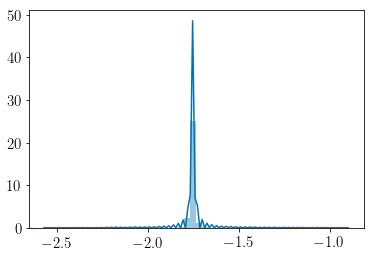

In [41]:
Mtrueval = np.median(d['Mtrue'],axis=0)
sns.distplot(Mtrueval)
Mtrueval.shape

In [35]:
d['Mtrue'].shape

(10000, 5570)

In [39]:
test.shape

(2, 5)

In [38]:
test = np.array([[1,1,1,1,1],[2,2,2,2,2]])
np.median(test,axis=1)

array([1., 2.])

#### Run the model

Finding separations, creating cov matrix...


/home/oliver/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


Done.


INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


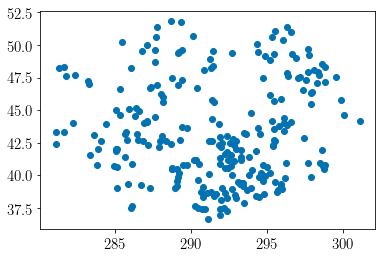

In [5]:
tempdiff = 50.0

from sklearn.utils import shuffle
ccd = shuffle(df).reset_index(drop=True)[:250]

rlebv = ccd.Aks.values
mband = ccd.Kmag.values
merr = ccd.e_Kmag.values

astres = read_paramdict('K_tempscale_noCorrection', str(tempdiff), 'astero')

Sigma = get_covmatrix(ccd)
logdetc = np.linalg.slogdet(Sigma)[1]
invc = np.linalg.inv(Sigma)

plt.scatter(ccd.ra, ccd.dec)
plt.show()

In [6]:
dat = {'N':len(ccd),
       'Nfloat':np.float(len(ccd)),
        'm': mband,
        'm_err': np.ones(len(mband))*10.e-3,
        'oo': ccd.parallax.values,
        'RlEbv': rlebv,
        'logdetc': logdetc,
        'invc': invc,
        'mu_init': astres['mu'].values[0],
        'mu_spread': astres['mu_std'].values[0]}

init= {'mu': astres.mu.values[0],
        'sigma': astres.sigma.values[0],
        'Q': astres.Q.values[0],
        'sigo': astres.sigo.values[0],
        'L': 1000.,
        'oo_zp':-29.}

In [9]:
fit = sm.sampling(data=dat, iter=5000, chains=4, seed=24601, 
                  init=[init,init, init, init])

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


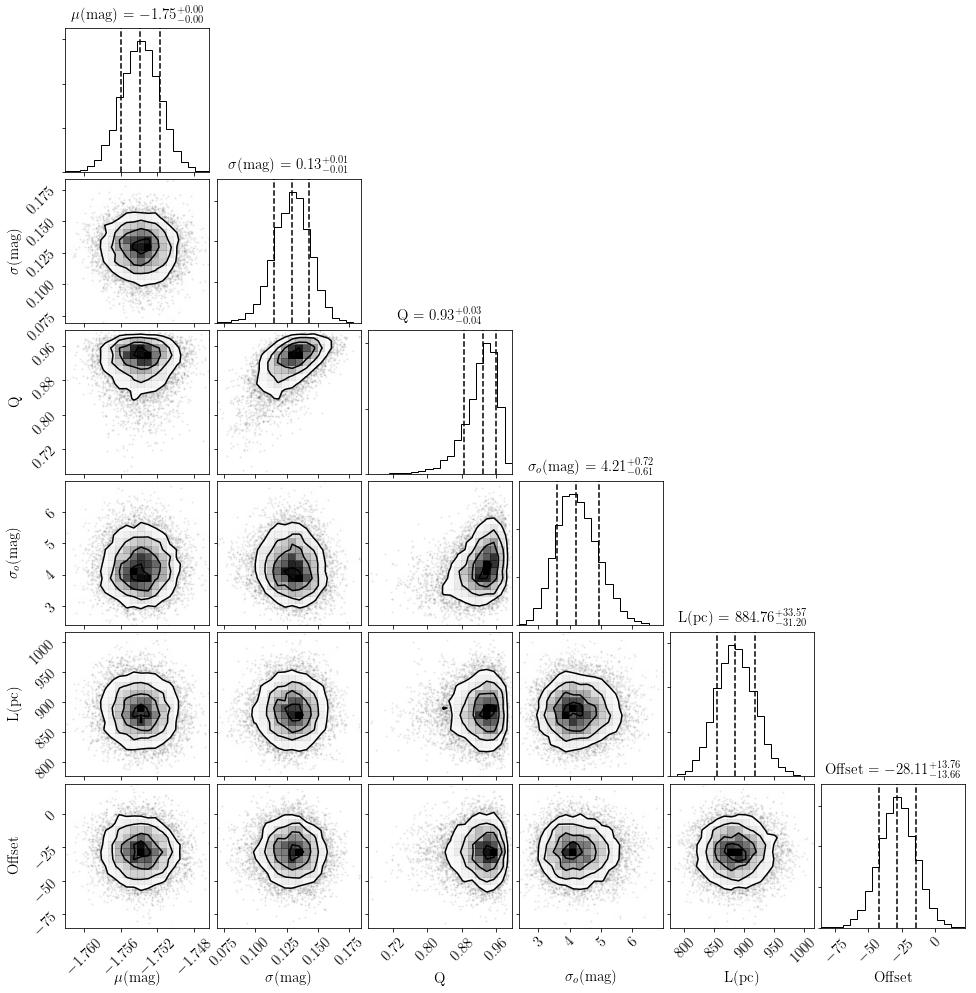

In [10]:
import corner
chain = np.array([fit['mu'],fit['sigma'],fit['Q'],fit['sigo'],fit['L'], fit['oo_zp']])
corner.corner(chain.T,\
                labels=[r'$\mu$(mag)',r'$\sigma$(mag)','Q',r'$\sigma_o$(mag)','L(pc)', 'Offset'],\
                quantiles=[0.16, 0.5, 0.84],\
                show_titles=True, title_kwargs={"fontsize": 15})
plt.show()

In [14]:
fit.plot()
plt.show()

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


RuntimeError: latex was not able to process the following string:
'oo_zp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/home/oliver/.cache/matplotlib/tex.cache/727c2d578108cf1e362c374cd961d1e3.tex
LaTeX2e <2017-04-15>
Babel <3.18> and hyphenation patterns for 84 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./727c2d578108cf1e362c374cd961d1e3.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.13 \fontsize{12.000000}{15.000000}{\rmfamily oo_
                                                  zp}
No pages of output.
Transcript written on 727c2d578108cf1e362c374cd961d1e3.log.




<Figure size 432x288 with 20 Axes>

In [18]:
import sys
matplotlib.__version__

'2.2.3'

In [15]:
print(fit)

Inference for Stan model: astrostan_ultcov_3c3fa0b344b0781a701aef1363099834.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu               -1.75  1.4e-5 2.1e-3  -1.76  -1.76  -1.75  -1.75  -1.75  23437    1.0
sigma             0.13  4.8e-4   0.01    0.1   0.12   0.13   0.14   0.16  930.0   1.01
sigo              4.25  6.6e-3   0.66   3.07   3.79   4.21   4.68   5.64  10046    1.0
Q                 0.92  1.1e-3   0.04   0.82    0.9   0.93   0.95   0.98 1231.0    1.0
L                885.7    0.24  32.58 822.99 863.17 884.76  907.3 952.64  18272    1.0
oo_zp           -28.12    0.11  13.71  -55.5 -37.25 -28.11 -18.77  -1.33  14563    1.0
M_infd_std[1]     2.43    0.02    1.2   0.54   1.59   2.21    3.1   5.21 3006.0    1.0
M_infd_std[2]    -0.25  7.1e-3   0.72  -1.72  -0.72  -0.25   0.25   1.14  10309    1.0
M_infd_std[3]     0.8

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


Total number of Rhats: 1007
Total number of Rhats with the NaN values removed: 1007
Total number of Rhats over 1.01: 0
Total number of Rhats over 1.1: 0


INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


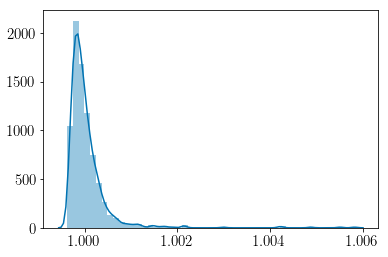

In [16]:
s = fit.summary()
rhat = s['summary'][:,-1]
rhatfin = rhat[np.isfinite(rhat)]
print('Total number of Rhats: '+str(len(rhat)))
print('Total number of Rhats with the NaN values removed: '+str(len(rhatfin)))
print('Total number of Rhats over 1.01: '+str(len(rhat[rhat > 1.01])))
print('Total number of Rhats over 1.1: '+str(len(rhat[rhat > 1.1])))
sns.distplot(rhatfin)
plt.show()

### Some further diagnostic plots

In [ ]:
mu = np.median(fit['mu'])
sigma = np.median(fit['sigma'])
sigo = (np.median(fit['sigo']))* sigma
Q = np.median(fit['Q'])
Minfd = np.median(fit['M_infd'],axis=0)
rinfd = np.median(fit['r_infd'],axis=0)
Linfd = np.median(fit['L'],axis=0)

x = np.linspace(Minfd.min(), Minfd.max(), 1000)
fg = normal(x, mu, sigma)
bg = normal(x, mu, sigo)
L = Q*fg + (1-Q)*bg

In [ ]:
left, bottom, width, height = 0.1, 0.47, 1., 0.60
fig = plt.figure(1, figsize=(8,8))
sax = fig.add_axes([left, bottom, width, height])
xax = fig.add_axes([left, 0.1, width, 0.3],sharex=sax)

sax.scatter(Minfd,mband,s=5,zorder=1000)

sns.distplot(Minfd, ax=xax, label='M obs')
xax.plot(x,fg,label='Foreground',zorder=999)
xax.plot(x,bg,label='Background',zorder=998)
xax.plot(x, L,label='True likelihood',zorder=997)
xax.legend()

sax.grid()
xax.grid()

sax.set_xlabel('Absmag in K')
sax.set_ylabel('App mag in K')
xax.set_ylabel('Units arbitrary')

The above plot compares the inferred absolute Kband magnitude to the observed absolute Kband magnitude--- there are more data points at the red clump overdensity which is expected, as the points will have been placed there within the constraints of the observational uncertainties. 

There appears to be some kind of offset still, as there appears to be some correlation around the bisector at the inferred absolute magnitude positions.

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
f = np.abs(ccd.parallax_error/ccd.parallax)
c = plt.scatter(ccd.r_est,rinfd,c=f, vmin=0., vmax=1.)
fig.colorbar(c, label='Fractional parallax uncertainty',extend='max')
ax.plot(ccd.r_est, ccd.r_est,c='k',linestyle='-.')
ax.set_xlabel('Inferred distance')
ax.set_ylabel('Bailer-Jones catalogue distance')
plt.show()
print('Our L: '+str(Linfd))
print('BJ+18 median L: '+str(np.median(ccd.r_length_prior)))

Given that our L is smaller, we expect the mode of the prior distribution to be at a **lower distance**, and therefore we expect stars with high fractional uncertainties to be have a **lower inferred distance**. This means we would expect high fractional uncertainty stars to be *below* the bisector. That appears to be the case, although we'll need to run on more stars to confirm.

In [ ]:
r = ccd.r_est
prior = (1/(2*Linfd**3)) * (r*r) * np.exp(-r/Linfd)

sns.distplot(ccd.r_est,label='r est')
sns.distplot(rinfd, label='r infd')
plt.scatter(r,prior,s=5,label='Prior')
plt.legend()
plt.show()

From this it looks like the best fit value of L does not comply well for the full dataset--- could this be because L varies as a function of galactic position?